**Pre-Processing**

We have a combined dataset now. The problem is, due to different sampling rates of different devices, for example, 180Hz for my Samsung S21 FE and 240Hz for my Samsung S24, for a given time, say 1 second, there are different amount of rows for different people. To normalize that, we will sample the data.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Here, we are printing basic data about the dataset collected, and showing some basic statistics, which, while not directly relevant, sometimes does provide some information about the data collected. Also, we check for any missing values.

In [3]:
import pandas as pd

file_path = "/content/drive/MyDrive/Major Project/Combined Datas/merged_data_with_persons.csv"
df = pd.read_csv(file_path)


print("Dataset Shape:", df.shape)
print("\nDataFrame Info:")
print(df.info())

print("\nFirst 5 Rows:")
print(df.head())
print("\nSummary Statistics:")
print(df.describe(include='all'))

print("\nMissing Values per Column:")
print(df.isnull().sum())

Dataset Shape: (5563805, 25)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5563805 entries, 0 to 5563804
Data columns (total 25 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          object 
 1   Accelerometer X    float64
 2   Accelerometer Y    float64
 3   Accelerometer Z    float64
 4   Gyroscope X        float64
 5   Gyroscope Y        float64
 6   Gyroscope Z        float64
 7   Magnetometer X     float64
 8   Magnetometer Y     float64
 9   Magnetometer Z     float64
 10  Rotation Vector X  float64
 11  Rotation Vector Y  float64
 12  Rotation Vector Z  float64
 13  Tilt Detector X    float64
 14  Tilt Detector Y    float64
 15  Tilt Detector Z    float64
 16  Auto-rotation X    float64
 17  Auto-rotation Y    float64
 18  Auto-rotation Z    float64
 19  Motion X           float64
 20  Motion Y           float64
 21  Motion Z           float64
 22  Last Touch X       float64
 23  Last Touch Y       float64
 24  Pers

### **For pre-processing, we have some steps to do.**

The first is to convert timestamp, from a string to datetime format, so it can be analyzed. Our goal here is to have a particular number of samples per unit time, hence this step is required. We also sort it by timestamp.

Then, we remove some outliers. Although, in long term, we would make sure that actual outliers are included (for example, someone with shaky hands because of panic/ stress/ fear currently would trigger an authentication request, since we are removing the outliers.)

To achieve this now, we are using Z-Score.

Next, we define 'sensor_columns' as all the columns except Timestamp and Person : 1 to 23.

Then, we group the data into time buckets. Currently, using any more sampling rate than 100ms is causing Google Colab to run out of memory, so we are using 100 ms.

Finally, we scale all the sensor data to be between 0 and 1 for now, and save the pre-processed data.

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from sklearn.preprocessing import MinMaxScaler


df['Timestamp'] = pd.to_datetime(df['Timestamp'])


df.sort_values('Timestamp', inplace=True)


sensor_columns = df.columns[1:24]

z_scores = np.abs(zscore(df[sensor_columns]))

mask = (z_scores < 3).all(axis=1)
df_clean = df[mask].copy()
print("After outlier removal:", df_clean.shape)


df_clean['Timestamp_bucket'] = df_clean['Timestamp'].dt.floor('100ms')

agg_dict = {col: 'mean' for col in sensor_columns}

df_grouped = df_clean.groupby(['Person', 'Timestamp_bucket']).agg(agg_dict).reset_index()

df_grouped.rename(columns={'Timestamp_bucket': 'Timestamp'}, inplace=True)
print("After timestamp bucketing by Person:", df_grouped.shape)


scaler = MinMaxScaler()
df_grouped[sensor_columns] = scaler.fit_transform(df_grouped[sensor_columns])

output_file_path = "/content/drive/MyDrive/Major Project/Combined Datas/merged_data_preprocessed_sample.csv"
df_grouped.to_csv(output_file_path, index=False)
print("Preprocessing complete. Final preprocessed data saved to:", output_file_path)

After outlier removal: (4944276, 25)
After timestamp bucketing by Person: (218594, 25)
Preprocessing complete. Final preprocessed data saved to: /content/drive/MyDrive/Major Project/Combined Datas/merged_data_preprocessed_sample.csv


For now, we are just comparing a small sample out of our dataset. Given below are examples of the 100ms sampling out of the full size of data that we have available:

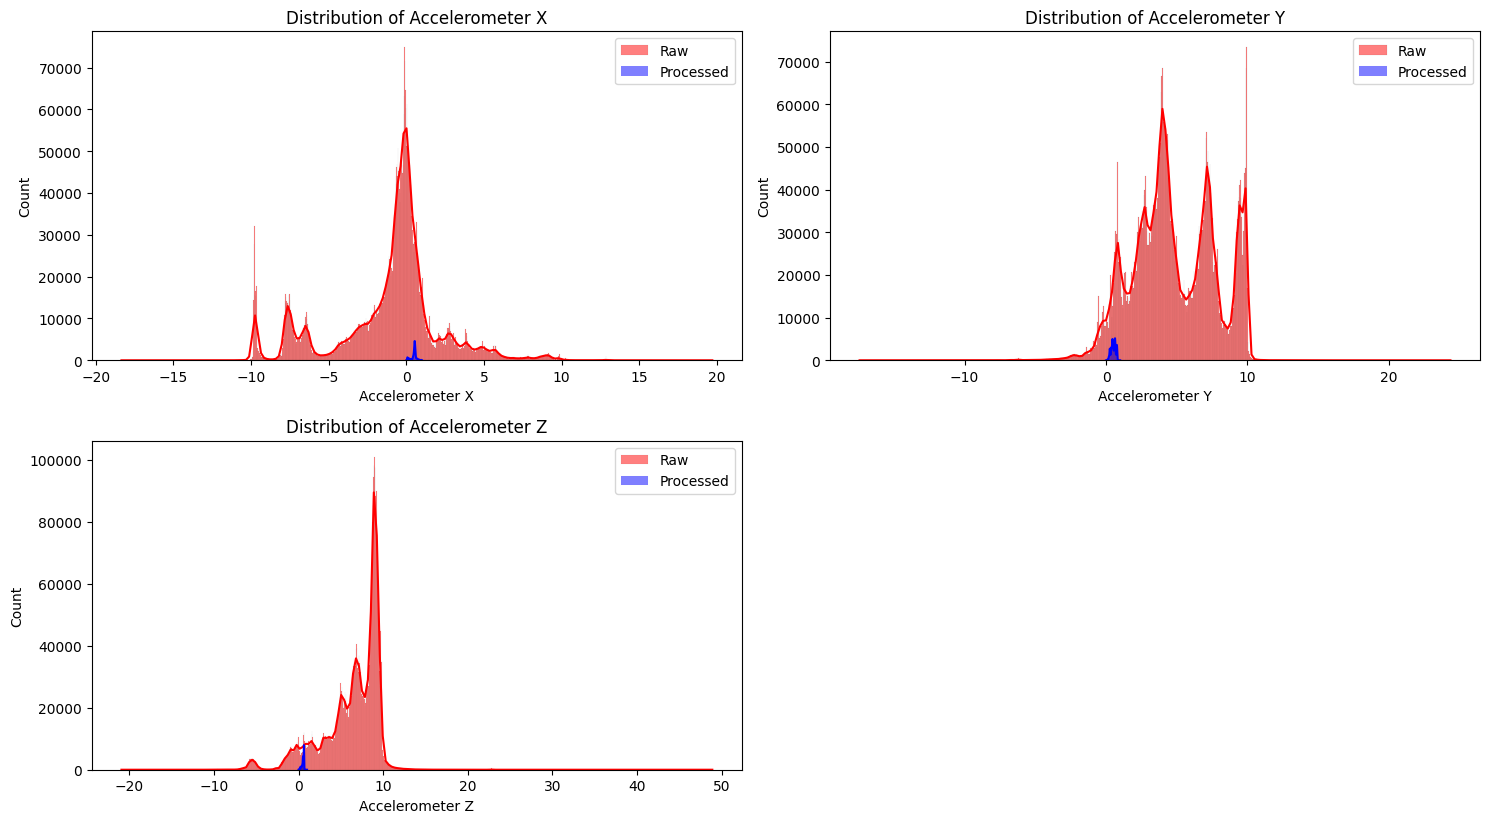

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

features = ["Accelerometer X", "Accelerometer Y", "Accelerometer Z",]

plt.figure(figsize=(15, 12))

for i, feature in enumerate(features):
    plt.subplot(3, 2, i+1)
    sns.histplot(df[feature], color='red', label='Raw', kde=True, alpha=0.5)
    sns.histplot(df_grouped[feature], color='blue', label='Processed', kde=True, alpha=0.5)
    plt.title(f"Distribution of {feature}")
    plt.legend()

plt.tight_layout()
plt.show()


### **Now, to apply LSTM.**

1. We load the pre-processed data, and ensure we have all the columns and all the persons. We had an issue before, where we werent able to get all the persons in the pre-processed data. Another issue was that person was getting treated as a numeric value, and timestamp was treated as a string.

2. Next, we split the dataset into train-test by person.

3. We learnt that LSTM works well with sequential data. It expects sequences of past sensor data over single values. It works great for our data. Hence, using a sliding window, we create sequences of sensor data over a fixed number of time steps. Here, we take that as 50. This helps LSTM understand patterns over time.

4. Next, we encode Person IDs into numerical labels.

5. Now, we have to build the LSTM model. For this, we use 2 LSTM layers:
- First LSTM: 64 units, returns sequences. Extracts time based patterns.
- Dropout (0.5): Reduces overfitting. (Randomly disables 50% of neurons)
- Second LSTM: 32 units, followed by another dropout. This summarises, whereas the first layer captures.
- Final Dense Layer: Uses softmax to classify the person. one user is chosen per sequence.

6. Training: For now, we are doing 10 epochs with a batch size of 64.





In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

preprocessed_file = "/content/drive/MyDrive/Major Project/Combined Datas/merged_data_preprocessed_sample.csv"
df = pd.read_csv(preprocessed_file, low_memory=False)
print("Preprocessed sample shape:", df.shape)
print("Columns in preprocessed CSV:", df.columns.tolist())
print("Unique Person values:", df["Person"].unique())

df["Person"] = df["Person"].astype(str)

df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df.sort_values('Timestamp', inplace=True)

# ---------------------------------------------------------------------------------------------------------------------

persons = df["Person"].unique()
train_persons, test_persons = train_test_split(persons, test_size=0.3, random_state=42)

train_df = df[df["Person"].isin(train_persons)]
test_df  = df[df["Person"].isin(test_persons)]
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

# ----------------------------------------------------------------------------------------------------

sensor_columns = [col for col in df.columns if col.lower() not in ["person", "timestamp"]]
print("Sensor columns used for sequences:", sensor_columns)

sequence_length = 50

def create_sequences(data, sensor_cols, seq_len):

    X, y = [], []
    data_values = data[sensor_cols].values
    labels = data["Person"].values
    n = len(data_values)
    for i in range(n - seq_len):
        X.append(data_values[i:i+seq_len])
        y.append(labels[i+seq_len])
    return np.array(X, dtype=np.float32), np.array(y)

X_train_seq, y_train_seq = create_sequences(train_df, sensor_columns, sequence_length)
X_test_seq, y_test_seq = create_sequences(test_df, sensor_columns, sequence_length)

print("X_train_seq shape:", X_train_seq.shape)
print("X_test_seq shape:", X_test_seq.shape)

# -------------------------------------------------------------------------------------------------------------

le = LabelEncoder()
le.fit(df["Person"].unique())

y_train_enc = le.transform(y_train_seq)
y_test_enc = le.transform(y_test_seq)
num_classes = len(le.classes_)
print("Number of classes:", num_classes)

if num_classes < 2:
    raise ValueError("Dataset has only one unique class. A classifier requires at least 2 classes.")


input_shape = X_train_seq.shape[1:]
model = Sequential([
    LSTM(64, input_shape=input_shape, return_sequences=True),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])
model.summary()

# ----------------------------------------------------------------------------------------------------------------------

history = model.fit(
    X_train_seq, y_train_enc,
    epochs=10,
    batch_size=64,
    validation_data=(X_test_seq, y_test_enc)
)

model_save_path = "/content/drive/MyDrive/Major Project/behavioral_biometrics_model_lstm_sample.h5"
model.save(model_save_path)
print("Model training complete and saved to:", model_save_path)


Preprocessed sample shape: (218594, 25)
Columns in preprocessed CSV: ['Person', 'Timestamp', 'Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyroscope X', 'Gyroscope Y', 'Gyroscope Z', 'Magnetometer X', 'Magnetometer Y', 'Magnetometer Z', 'Rotation Vector X', 'Rotation Vector Y', 'Rotation Vector Z', 'Tilt Detector X', 'Tilt Detector Y', 'Tilt Detector Z', 'Auto-rotation X', 'Auto-rotation Y', 'Auto-rotation Z', 'Motion X', 'Motion Y', 'Motion Z', 'Last Touch X', 'Last Touch Y']
Unique Person values: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]
Train set shape: (161767, 25)
Test set shape: (56827, 25)
Sensor columns used for sequences: ['Accelerometer X', 'Accelerometer Y', 'Accelerometer Z', 'Gyroscope X', 'Gyroscope Y', 'Gyroscope Z', 'Magnetometer X', 'Magnetometer Y', 'Magnetometer Z', 'Rotation Vector X', 'Rotation Vector Y', 'Rotation Vector Z', 'Tilt Detector X', 'Tilt Detector Y', 'Tilt Detector Z', 'Auto-rotation X', 'Auto-rotation Y'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50, 64)              │          22,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │             825 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,769 (139.72 KB)

 Trainable params: 35,769 (139.72 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 204s 79ms/step - accuracy: 0.7003 - loss: 0.9647 - val_accuracy: 0.0000e+00 - val_loss: 10.1045
Epoch 2/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 219s 86ms/step - accuracy: 0.8773 - loss: 0.3165 - val_accuracy: 0.0000e+00 - val_loss: 10.5150
Epoch 3/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 242s 78ms/step - accuracy: 0.8973 - loss: 0.2453 - val_accuracy: 0.0000e+00 - val_loss: 12.5953
Epoch 4/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 199s 77ms/step - accuracy: 0.9044 - loss: 0.2173 - val_accuracy: 0.0000e+00 - val_loss: 14.3187
Epoch 5/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 227s 87ms/step - accuracy: 0.9085 - loss: 0.1961 - val_accuracy: 0.0000e+00 - val_loss: 15.3540
Epoch 6/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 238s 77ms/step - accuracy: 0.9164 - loss: 0.1711 - val_accuracy: 0.0000e+00 - val_loss: 15.5998
Epoch 7/10
2527/2527 ━━━━━━━━━━━━━━━━━━━━ 201s 77ms/step - accuracy: 0.9126 - loss: 0.1883 - val_accuracy: 0.0000e+00 - val_loss: 18.2285
Epoch 8/10
2527/2527 ━━━━━━━━━━━━━

Model training complete and saved to: /content/drive/MyDrive/Major Project/behavioral_biometrics_model_lstm_sample.h5


Now, to visualise the applied model:

1. Accuray and Loss graphs

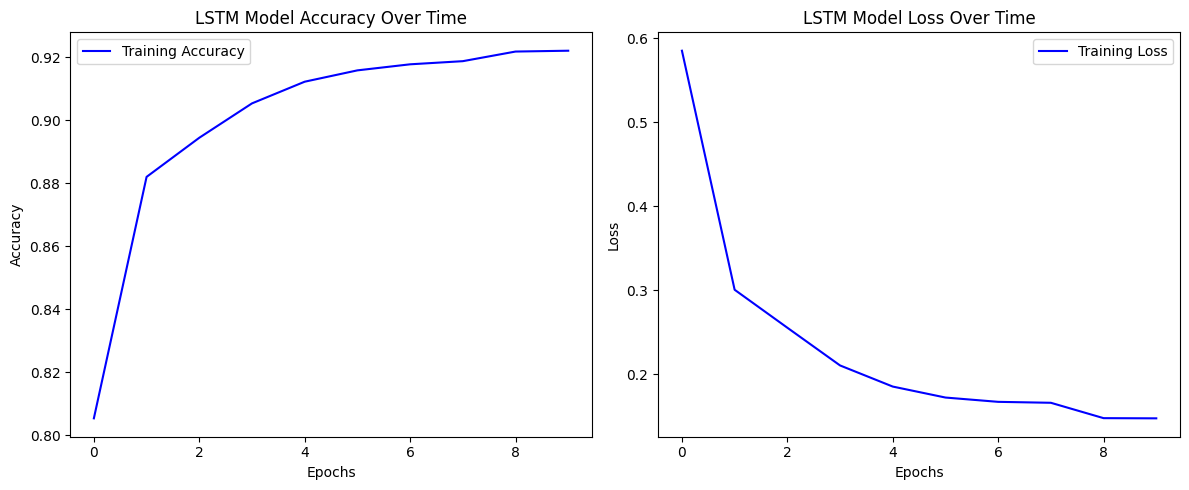

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Training Accuracy", color='blue')
# plt.plot(history.history['val_accuracy'], label="Validation Accuracy", color='red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("LSTM Model Accuracy Over Time")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Training Loss", color='blue')
# plt.plot(history.history['val_loss'], label="Validation Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("LSTM Model Loss Over Time")
plt.legend()

plt.tight_layout()
plt.show()


2. Confusion Matrix

1775/1775 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step


ValueError: The number of FixedLocator locations (22), usually from a call to set_ticks, does not match the number of labels (25).

<Figure size 1000x800 with 0 Axes>

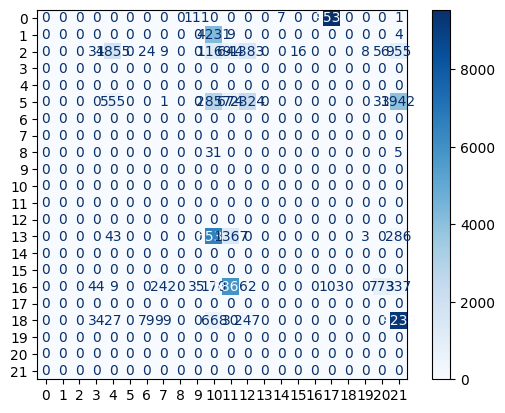

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test_seq)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test_enc, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(10, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for LSTM Model")
plt.show()
